# imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import shutil
from matplotlib import pyplot as plt

In [2]:
os.chdir('../')

# understanding data

In [3]:
BATCH_SIZE = 16

In [4]:
im = Image.open('cnn_data/benign/1.png')
# im.show()
image_size = im.size

In [5]:
data_path_img = 'cnn_data/'
folders = os.listdir(data_path_img)

shapes = set()
for folder in folders:
    for file in os.listdir(data_path_img+folder):
        path = f"{data_path_img}{folder}/{file}"
        # 
        im = Image.open(path)
        im = np.array(im)

        if (len(im.shape)==3 and im.shape[2]!=3) or (len(im.shape)==2):
            print('delete:', path)
            os.remove(path)


# for file in os.listdir(data_path_img):
#     im = Image.open(data_path_img+file)
#     im = np.array(im)
#     # print(f"file: {len(im.shape)}")
#     if len(im.shape) == 3 and im.shape[2]==2:
#         print(f"delete: {file}")
#         # os.remove(data_path_img+file)
#         # os.remove(data_path_mask+file)

In [6]:
class_mapping = {
    'benign': 0,
    'malignant': 1,
    'normal': 2,
}
data_path_img = 'cnn_data/'
folders = os.listdir(data_path_img)

paths, classes = [], []
for folder in folders:
    for file in os.listdir(data_path_img+folder):
        path = f"{data_path_img}{folder}/{file}"
        _class = class_mapping[folder]
        paths.append(path)
        classes.append(_class)
# paths, classes

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    paths, classes,
    test_size=.33,
    random_state=42
)

In [8]:
train_df = pd.DataFrame({'path': X_train, 'class': y_train})
val_df = pd.DataFrame({'path': X_test, 'class': y_test})
train_df, val_df

(                           path  class
 0        cnn_data/normal/86.png      2
 1       cnn_data/benign/214.png      0
 2       cnn_data/benign/108.png      0
 3       cnn_data/benign/434.png      0
 4        cnn_data/normal/39.png      2
 ..                          ...    ...
 511   cnn_data/malignant/17.png      1
 512   cnn_data/malignant/23.png      1
 513     cnn_data/benign/170.png      0
 514     cnn_data/benign/122.png      0
 515  cnn_data/malignant/137.png      1
 
 [516 rows x 2 columns],
                          path  class
 0     cnn_data/normal/100.png      2
 1     cnn_data/benign/429.png      0
 2      cnn_data/normal/95.png      2
 3     cnn_data/benign/136.png      0
 4       cnn_data/normal/5.png      2
 ..                        ...    ...
 250   cnn_data/benign/324.png      0
 251    cnn_data/normal/14.png      2
 252  cnn_data/malignant/3.png      1
 253   cnn_data/benign/187.png      0
 254    cnn_data/benign/52.png      0
 
 [255 rows x 2 columns])

In [9]:
train_df.sample(frac=1).reset_index(drop=True)

,path,class
0,cnn_data/malignant/22.png,1
1,cnn_data/benign/419.png,0
2,cnn_data/benign/239.png,0
3,cnn_data/benign/418.png,0
4,cnn_data/malignant/46.png,1
...,...,...
511,cnn_data/benign/137.png,0
512,cnn_data/benign/367.png,0
513,cnn_data/malignant/36.png,1
514,cnn_data/benign/310.png,0


# DataGenerator

In [10]:
class CNNDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size=16, shuffle=True):
        self.df = df.copy()
        self.df = self.df.sample(frac=1).reset_index(drop=True)

        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    

    def __get_input(self, paths):
        out = []

        for path in paths:
            im = Image.open(path)
            im = im.crop((57,0,505,448))
            im = np.array(im)/255.

            out.append(im)

        return out


    def __get_output(self, labels):
        out = []

        for label in labels:
            out.append(label)

        return out


    def __get_data(self, batches):
        paths = batches[self.X_col]
        X = self.__get_input(paths)
        labels = batches[self.y_col]
        y = self.__get_output(labels)

        X = np.array(X)
        y = np.array(y)
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.int32)
        return X,y


    def __getitem__(self, index):
        batches = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        X,y = self.__get_data(batches)
        return X,y


    def get_all_data(self):
        paths = self.df[self.X_col]
        labels = self.df[self.y_col]

        outX = []

        for path in paths:
            im = Image.open(path)
            im = im.crop((57,0,505,448))
            im = np.array(im)/255.

            outX.append(im)

        outy = []

        for label in labels:
            outy.append(label)

        return outX, outy


    def __len__(self):
        return self.n // self.batch_size


In [11]:
data_dir = 'cnn_data/'
image_size = (448,448)
BATCH_SIZE=16

traingen = CNNDataGenerator(train_df, 'path', 'class', BATCH_SIZE)
valgen = CNNDataGenerator(val_df, 'path', 'class', BATCH_SIZE)
traingen, valgen

(<__main__.CNNDataGenerator at 0x1747a3400>,
 <__main__.CNNDataGenerator at 0x1747a38b0>)

In [46]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

In [49]:
train_X, train_y = traingen.get_all_data()
train_X = np.array(train_X)

In [50]:
train_X = datagen.flow(
    train_X,
    train_y,
    batch_size=16
)

In [42]:
img = np.array(traingen.__getitem__(0)[0][0]*255, dtype=int)
label = np.array(traingen.__getitem__(0)[1][0])

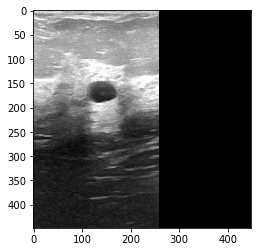

In [43]:
img = img.astype('int')
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
label

array(0, dtype=int32)

# modelling

In [ ]:
# import all of the models
from models import (
    ClassWeightMult,
    efficient_net_b7,
    efficient_net_v2s,
    inception_v3,
    resnet50,
    seq_model,
    simple_seq_model,
    vgg16
)

In [ ]:
im_size = (448,448,3)
verbose = 1
data_dir = 'cnn_data/'
n_classes=3

In [ ]:
# class_weight calculation
class_names = os.listdir(data_dir)
class_sizes = [len(os.listdir(f"{data_dir}{c}/")) for c in class_names]
total_images = sum(class_sizes)

class_weight = [total_images/(n_classes*n_samples) for n_samples in class_sizes]
class_names, class_sizes, class_weight

(['malignant', 'benign', 'normal'],
 [210, 428, 133],
 [1.223809523809524, 0.6004672897196262, 1.9323308270676691])

In [23]:
w = dict()
for name, weight in zip(class_names, class_weight):
    w[name] = weight
w

cw = [w['benign'], w['malignant'], w['normal']]
cw

[0.6004672897196262, 1.223809523809524, 1.9323308270676691]

# EfficientNet B7

In [24]:
model = efficient_net_b7.efficient_net_b7(cw, input_shape=im_size)
model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 448, 448, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 448, 448, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 449, 449, 3)  0           ['normalization[0][0]']      

In [25]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [26]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/enb7/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [27]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2


KeyboardInterrupt: 

In [51]:
from sklearn.metrics import f1_score

dataX, datay = valgen.get_all_data()
pred = model.predict(np.array(dataX))
acc = datay

In [52]:
pred[0]
pred_new = []
for p in pred:
    # m = max(p)
    pred_new.append(np.argmax(p))
pred_new = np.array(pred_new)
np.min(pred_new)

2

In [53]:
np.max(pred_new)

2

In [55]:
pred=pred_new
f1_score(acc, pred, average='micro')

0.16470588235294117

# EfficientNet V2S

In [ ]:
model = efficient_net_v2s.efficient_net_v2s(
    cw, input_shape=im_size
)
model

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 448, 448, 3)  0           ['input_9[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 224, 224, 24  648         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/env2s/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.4766 - f1_score: 0.4329
Epoch 1: loss improved from inf to 1.07406, saving model to checkpoints/env2s/
INFO:tensorflow:Assets written to: checkpoints/env2s/assets
32/32 [==============================] - 52s 1s/step - loss: 1.0741 - accuracy: 0.4766 - f1_score: 0.4329 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 0.9699 - accuracy: 0.5020 - f1_score: 0.4343
Epoch 2: loss improved from 1.07406 to 0.96989, saving model to checkpoints/env2s/
INFO:tensorflow:Assets written to: checkpoints/env2s/assets
32/32 [==============================] - 43s 1s/step - loss: 0.9699 - accuracy: 0.5020 - f1_score: 0.4343 - lr: 0.0010


# InceptionV3

In [ ]:
model = inception_v3.inception_v3(
    cw,
    input_shape=im_size
)
model

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 223, 223, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 223, 223, 32  96         ['conv2d_106[0][0]']             
 ormalization)                  )                                                           

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/inv3/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 0.9300 - accuracy: 0.5859 - f1_score: 0.4314
Epoch 1: loss improved from inf to 0.92997, saving model to checkpoints/inv3/
INFO:tensorflow:Assets written to: checkpoints/inv3/assets
32/32 [==============================] - 24s 635ms/step - loss: 0.9300 - accuracy: 0.5859 - f1_score: 0.4314 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7812 - f1_score: 0.4338
Epoch 2: loss improved from 0.92997 to 0.55170, saving model to checkpoints/inv3/
INFO:tensorflow:Assets written to: checkpoints/inv3/assets
32/32 [==============================] - 20s 615ms/step - loss: 0.5517 - accuracy: 0.7812 - f1_score: 0.4338 - lr: 0.0010


# ResNet50

In [ ]:
model = resnet50.resnet50(
    cw,
    input_shape=im_size,
)
model

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/resnet/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 1.3479 - accuracy: 0.4668 - f1_score: 0.4309
Epoch 1: loss improved from inf to 1.34789, saving model to checkpoints/resnet/
INFO:tensorflow:Assets written to: checkpoints/resnet/assets
32/32 [==============================] - 45s 1s/step - loss: 1.3479 - accuracy: 0.4668 - f1_score: 0.4309 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.4922 - f1_score: 0.4319
Epoch 2: loss improved from 1.34789 to 1.12832, saving model to checkpoints/resnet/
INFO:tensorflow:Assets written to: checkpoints/resnet/assets
32/32 [==============================] - 40s 1s/step - loss: 1.1283 - accuracy: 0.4922 - f1_score: 0.4319 - lr: 0.0010


# seq_model

In [ ]:
model = seq_model.seq_model(
    cw, input_shape=im_size
)
model

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 batch_normalization_190 (Ba  (None, 448, 448, 3)      12        
 tchNormalization)                                               
                                                                 
 conv2d_200 (Conv2D)         (None, 448, 448, 64)      4864      
                                                                 
 conv2d_201 (Conv2D)         (None, 448, 448, 64)      102464    
                                                                 
 conv2d_202 (Conv2D)         (None, 448, 448, 64)      36928     
                                                                 
 conv2d_203 (Conv2D)         (None, 448, 448, 64)      36928     
                                                          

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/seqmodel/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 6.5344 - accuracy: 0.5137 - f1_score: 0.4334
Epoch 1: loss improved from inf to 6.53442, saving model to checkpoints/seqmodel/
INFO:tensorflow:Assets written to: checkpoints/seqmodel/assets
32/32 [==============================] - 163s 5s/step - loss: 6.5344 - accuracy: 0.5137 - f1_score: 0.4334 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 6.8895 - accuracy: 0.5586 - f1_score: 0.4329
Epoch 2: loss did not improve from 6.53442
32/32 [==============================] - 114s 4s/step - loss: 6.8895 - accuracy: 0.5586 - f1_score: 0.4329 - lr: 0.0010


# simple seq model

In [ ]:
model = simple_seq_model.simple_seq_model(
    cw, im_size
)
model

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 batch_normalization_191 (Ba  (None, 448, 448, 3)      12        
 tchNormalization)                                               
                                                                 
 conv2d_208 (Conv2D)         (None, 148, 148, 64)      6976      
                                                                 
 conv2d_209 (Conv2D)         (None, 48, 48, 64)        147520    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 64)        0  

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/simpleseqmodel/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.4941 - f1_score: 0.4329
Epoch 1: loss improved from inf to 1.09177, saving model to checkpoints/simpleseqmodel/
INFO:tensorflow:Assets written to: checkpoints/simpleseqmodel/assets
32/32 [==============================] - 7s 172ms/step - loss: 1.0918 - accuracy: 0.4941 - f1_score: 0.4329 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.5508 - f1_score: 0.4329
Epoch 2: loss improved from 1.09177 to 0.98622, saving model to checkpoints/simpleseqmodel/
INFO:tensorflow:Assets written to: checkpoints/simpleseqmodel/assets
32/32 [==============================] - 5s 164ms/step - loss: 0.9862 - accuracy: 0.5508 - f1_score: 0.4329 - lr: 0.0010


# VGG16

In [ ]:
model = vgg16.vgg16(
    cw, input_shape=im_size,
)
model

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0  

In [ ]:
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    'accuracy',
    tfa.metrics.F1Score(3, 'micro')
]

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
# callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    verbose=verbose,
    cooldown=3, 
    min_lr=1e-10
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "checkpoints/vgg16/", 
    save_best_only=True,
    monitor='loss',
    verbose=verbose
)

callbacks = [lr_reduction, checkpoint]

In [ ]:
EPOCHS = 2

model.fit(
    traingen,
    # validation_data=valgen,
    epochs=EPOCHS,
    verbose=verbose,
    callbacks=callbacks,
)

Epoch 1/2
32/32 [==============================] - ETA: 0s - loss: 1.3061 - accuracy: 0.4629 - f1_score: 0.4334
Epoch 1: loss improved from inf to 1.30606, saving model to checkpoints/vgg16/
INFO:tensorflow:Assets written to: checkpoints/vgg16/assets
32/32 [==============================] - 32s 956ms/step - loss: 1.3061 - accuracy: 0.4629 - f1_score: 0.4334 - lr: 0.0010
Epoch 2/2
32/32 [==============================] - ETA: 0s - loss: 1.0223 - accuracy: 0.5020 - f1_score: 0.4324
Epoch 2: loss improved from 1.30606 to 1.02226, saving model to checkpoints/vgg16/
INFO:tensorflow:Assets written to: checkpoints/vgg16/assets
32/32 [==============================] - 31s 955ms/step - loss: 1.0223 - accuracy: 0.5020 - f1_score: 0.4324 - lr: 0.0010
